Import Libraries

In [1]:
import numpy as np
import seaborn as ans
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten,Activation,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
#Data augmentation is commonly used in rice leaf disease classification to increase the size and diversity of the training dataset. #
#It involves applying various transformations to the existing images, creating new augmented versions of the original images.#
from tensorflow.keras.preprocessing.image import ImageDataGenerator



#transfer learning
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.xception import Xception

#warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
input_shape_2D=(224,224) # here i'm fixeing the image shape in 2D
input_shape_3D= (224,224,3) # here i'm fixeing the image shape in 2D
seed=1    # assign seed
batch_size=32  #assigning batch size
epochs=30

 Loading image data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory=r'/content/drive/MyDrive/rice_leaf_diseases',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seed
)

Found 120 files belonging to 3 classes.


In [6]:
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


In [7]:
def show_images(images, labels):
    fig, axes = plt.subplots(8, 4, figsize=(10, 10))
    axes = axes.flatten()
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.numpy().astype("uint8"))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

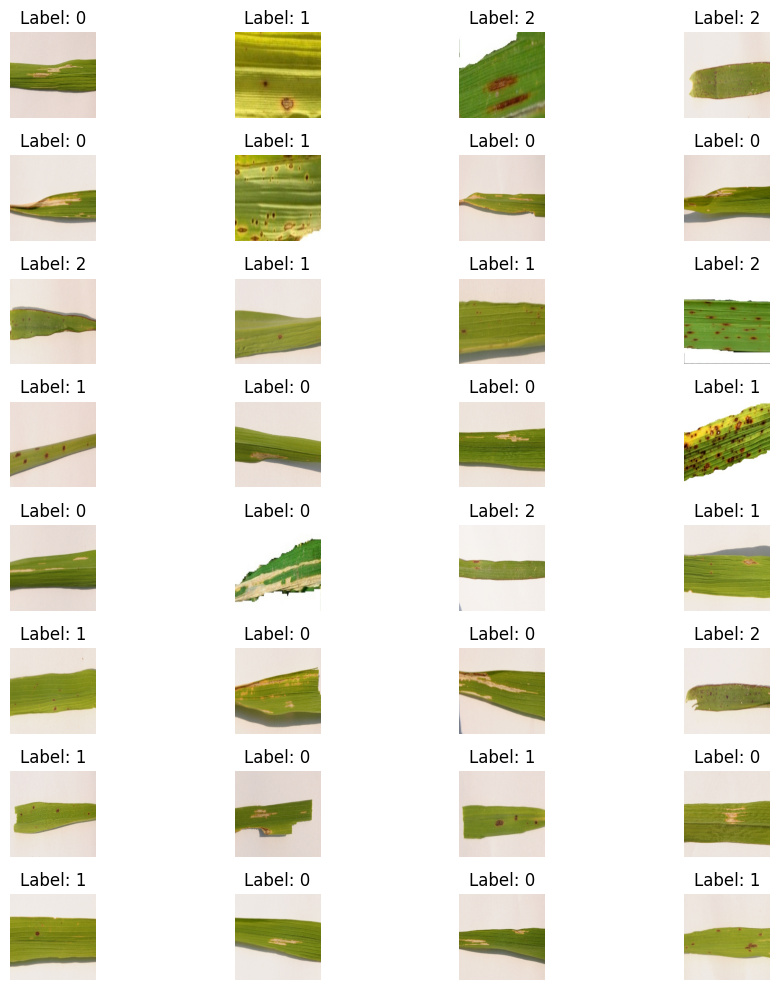

In [8]:
#displaying image batch of 32
batched_ds = data_ds.batch(batch_size)

batch = next(iter(batched_ds))
images, labels = batch

images, labels = next(iter(batched_ds))
show_images(images, labels)

 Data preprocessing

In [9]:
X=[]
y= []

for image, label in data_ds.batch(119):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())

In [10]:
# converting to numpy array
X= np.array(X)
y= np.array(y)

In [11]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [12]:
# reshaping the image size

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# getting X_train,X_test,y_train,y_test shape

print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (90, 224, 224, 3)
shape of y_train: (90,)
shape of X_test_scaled: (30, 224, 224, 3)
shape of y_test: (30,)


Encoding


In [13]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

Creating CNN Architecture

In [14]:

model = Sequential()
model.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(250,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(3,activation='softmax'))


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 32)     │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │       256,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,765 (2.57 MB)

 Trainable params: 673,765 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [16]:
# assigning optimizer,loss and accuracy what we want
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [19]:
checkpointer = ModelCheckpoint(filepath = "model.weights.best.keras",save_best_only=False,mode='max',monitor="val_accuracy")

In [20]:
epoch = 30 # assigning epochs and fitting the model with some parameters
history = model.fit(X_train,y_train,batch_size=32,epochs=epoch,validation_data=(X_test,y_test),callbacks=[checkpointer],
              verbose=1,shuffle=True)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3168 - loss: 1.1163 - val_accuracy: 0.1333 - val_loss: 1.1813
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4109 - loss: 1.0762 - val_accuracy: 0.1333 - val_loss: 1.1125
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2867 - loss: 1.1085 - val_accuracy: 0.3667 - val_loss: 1.1026
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3992 - loss: 1.0853 - val_accuracy: 0.1333 - val_loss: 1.1350
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4087 - loss: 1.0723 - val_accuracy: 0.1333 - val_loss: 1.1534
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4243 - loss: 1.0485 - val_accuracy: 0.1333 - val_loss: 1.2115
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4070 - loss: 1.0413 - val_accuracy: 0.1667 - val_loss: 1.2099
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4286 - loss: 1.0417 - val_accuracy: 0.2000 - val_loss: 1.137

In [21]:
scores = model.evaluate(X_test, y_test)  # checking the accuracy
accuracys = 100*scores[1]    # saving the accuracy in variable

# print test accuracy
print('Test accuracy: %.4f%%' % accuracys)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6000 - loss: 1.2727
Test accuracy: 60.0000%


In [22]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()


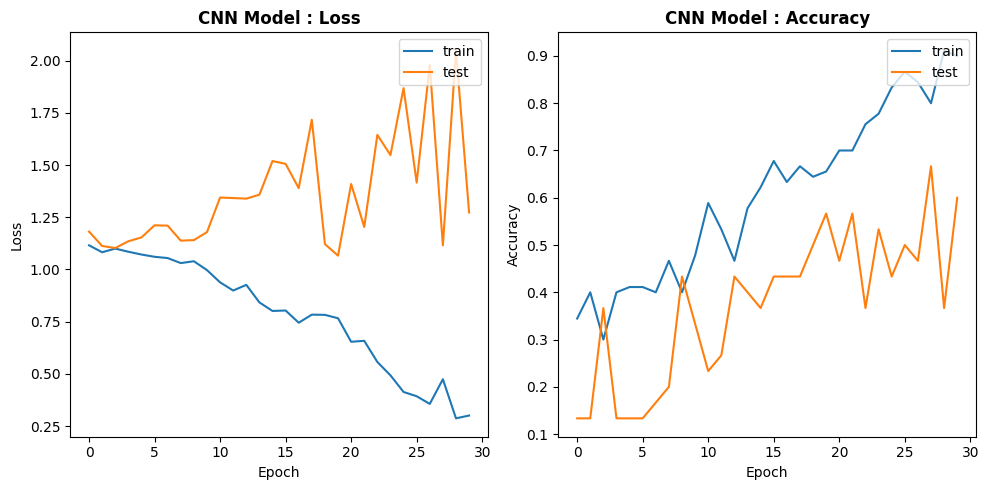

In [23]:
plot_performance(model_name= 'CNN Model',
                 acc=history.history['accuracy'],
                 val_acc=history.history['val_accuracy'],
                 loss=history.history['loss'],
                 val_loss=history.history['val_loss'])

Data Augmentation

In [24]:
#creating image generator object
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

In [25]:

model1 = Sequential()
model1.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros',input_shape=(224,224,3)))
model1.add(MaxPooling2D(pool_size=3))
model1.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model1.add(MaxPooling2D(pool_size=3))
model1.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model1.add(MaxPooling2D(pool_size=3))
model1.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.16))
model1.add(Flatten())
model1.add(Dropout(0.27))
model1.add(Dense(500,activation='relu'))
model1.add(Dense(100,activation='relu'))
model1.add(Dense(3,activation='softmax'))


model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 74, 74, 32)     │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 500)            │       512,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 955,015 (3.64 MB)

 Trainable params: 955,015 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# assigning optimizer,loss and accuracy what we want
model1.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
#training model with Data Augmentation
epoch1 = 30


checkpointer_own_aug = ModelCheckpoint(filepath='own_model_aug.weights.best.keras', verbose=6,monitor="val_accuracy",) # changed extension from hdf5 to keras

aug_history= model1.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epoch1,
    shuffle=True,
    callbacks=[checkpointer_own_aug]
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2888 - loss: 1.1190
Epoch 1: saving model to own_model_aug.weights.best.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.3017 - loss: 1.1182 - val_accuracy: 0.1333 - val_loss: 1.1820
Epoch 2/30
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3750 - loss: 1.0917
Epoch 2: saving model to own_model_aug.weights.best.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3750 - loss: 1.0917 - val_accuracy: 0.1333 - val_loss: 1.1659
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.3359 - loss: 1.1086
Epoch 3: saving model to own_model_aug.weights.best.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step - accuracy: 0.3333 - loss: 1.1084 - val_accuracy: 0.4333 - val_loss: 1.0753
Epoch 4/30
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2692 - loss: 1.1185
Epoch 4: saving model to own_model_aug.weights.best.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2692 - loss: 1.1185 - val_accuracy: 0.433

In [29]:
score1 = model1.evaluate(X_test, y_test) # predicting the model
accuracy1 = 100*score1[1] # saving the accuracy in variable

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2000 - loss: 1.2139
Test accuracy: 20.0000%


In [30]:
# define plot for ploting graph of model_name, acc, val_acc, loss, val_loss

def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

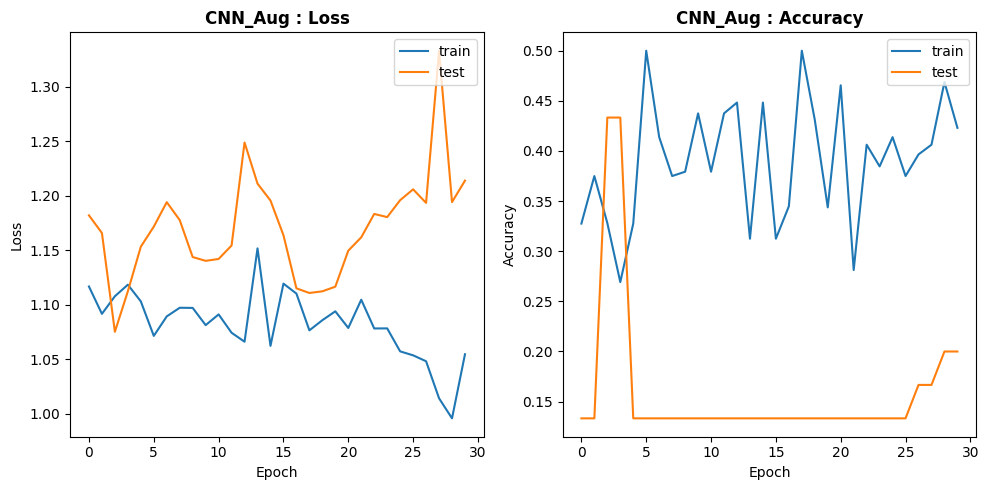

In [31]:
#visualising model performance
plot_performance(model_name='CNN_Aug',
                  acc=aug_history.history['accuracy'],
                 val_acc=aug_history.history['val_accuracy'],
                 loss=aug_history.history['loss'],
                 val_loss=aug_history.history['val_loss'])

Inception V3

In [32]:
inception_base=tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape_3D,
)

#unfreezing the convloution layers
inception_base.trainable=True
set_trainable=False

for layer in inception_base.layers:
  if layer.name=='mixed9_0':
    set_trainable=True

  if set_trainable==True:
    layer.trainable=True

  else:
    layer.trainable=False


# building fully connected layers
inception_model= Sequential()

inception_model.add(inception_base)
inception_model.add(Flatten())

inception_model.add(Dense(128, activation='relu'))
inception_model.add(Dense(3, activation='softmax'))


#compiling
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [33]:
# Build the model
def build_inception_model():
    model = Sequential()
    model.add(inception_base)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

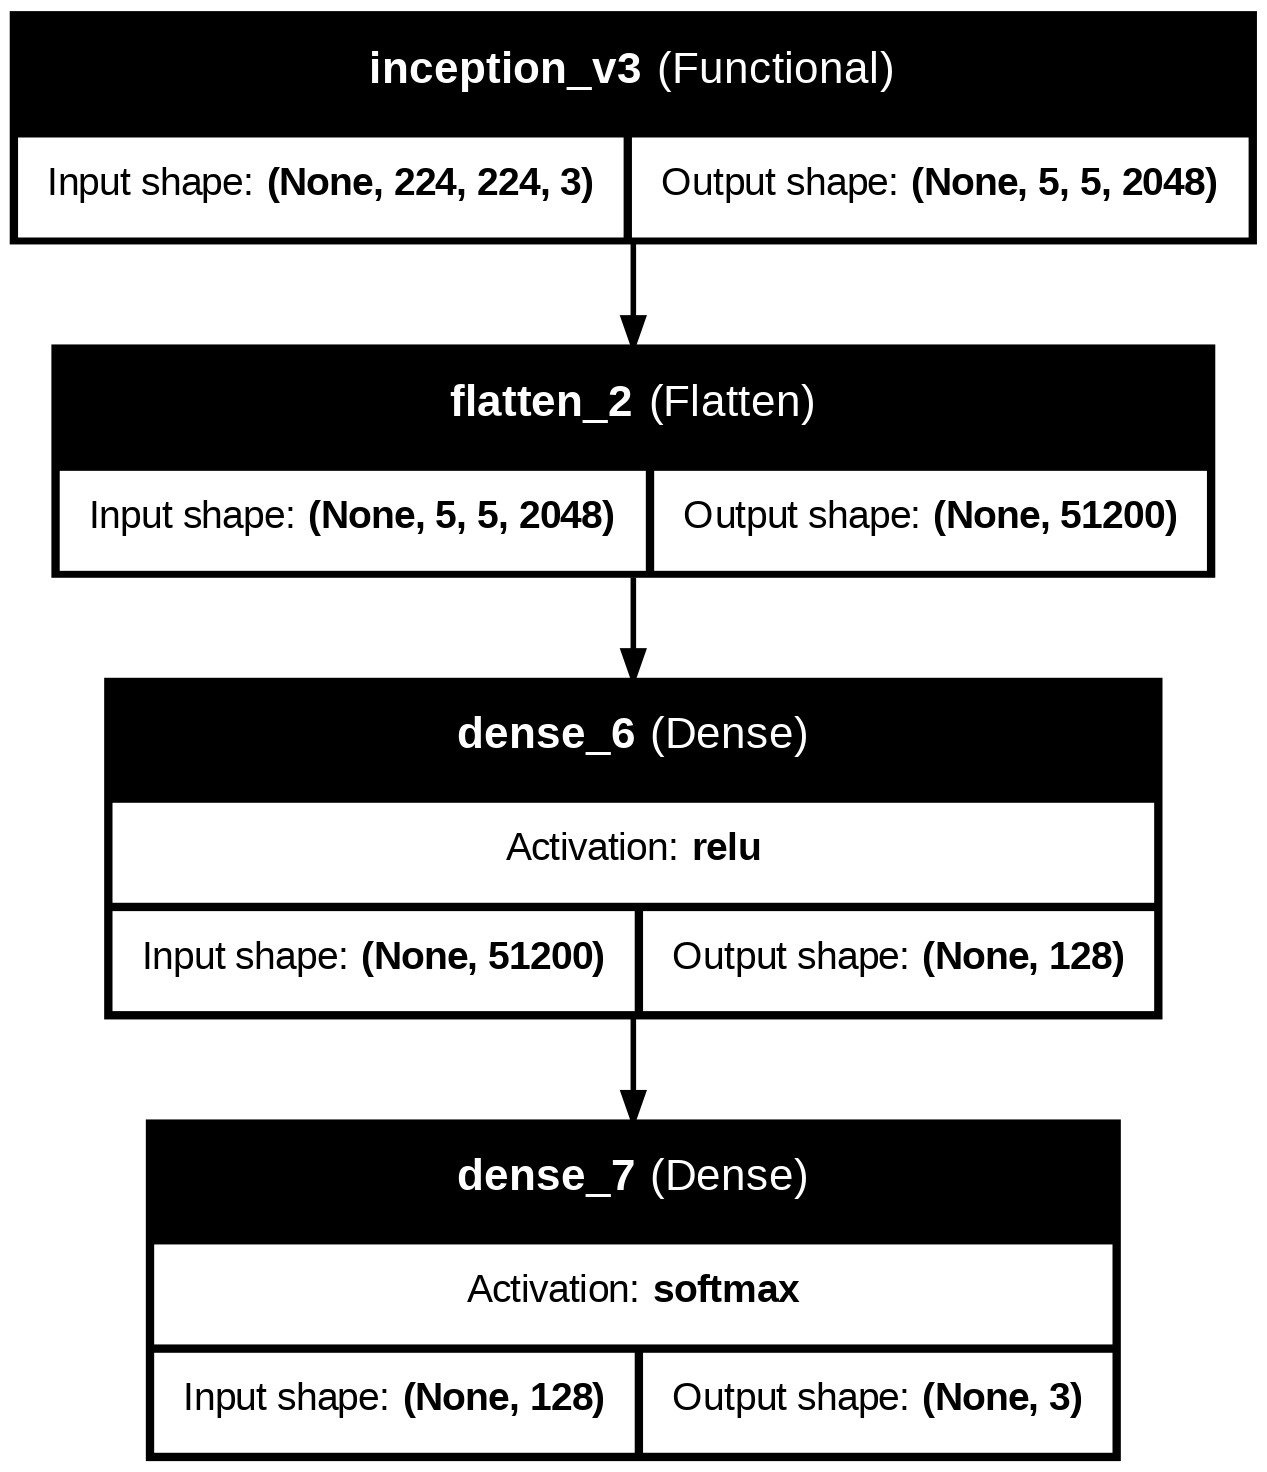

In [34]:
tf.keras.utils.plot_model(
    inception_model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True
)

Without Augmentation

In [37]:
# Train without data augmentation
inception_model = build_inception_model()
checkpointer_inception = ModelCheckpoint(filepath='inception.weights.best.keras', verbose=1, save_best_only=True) # changed extension from hdf5 to keras
inception_history = inception_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[checkpointer_inception]
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4569 - loss: 9.6315  
Epoch 1: val_loss improved from inf to 48.91651, saving model to inception.weights.best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - accuracy: 0.4510 - loss: 10.9308 - val_accuracy: 0.1667 - val_loss: 48.9165
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5377 - loss: 12.0511
Epoch 2: val_loss improved from 48.91651 to 6.70611, saving model to inception.weights.best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 970ms/step - accuracy: 0.5644 - loss: 10.9271 - val_accuracy: 0.7667 - val_loss: 6.7061
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9800 - loss: 0.3879 
Epoch 3: val_loss did not improve from 6.70611
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9739 - loss: 0.5402 - val_accuracy: 0.7667 - val_loss: 11.1809
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8990 - loss: 0.9179
Epoch 4: val_loss did not improve from 6.70611
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 12

In [38]:
score2 = inception_model.evaluate(X_test, y_test)
accuracy2 = 100 * score2[1]
print('Test accuracy without augmentation: %.4f%%' % accuracy2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9000 - loss: 5.3476
Test accuracy without augmentation: 90.0000%


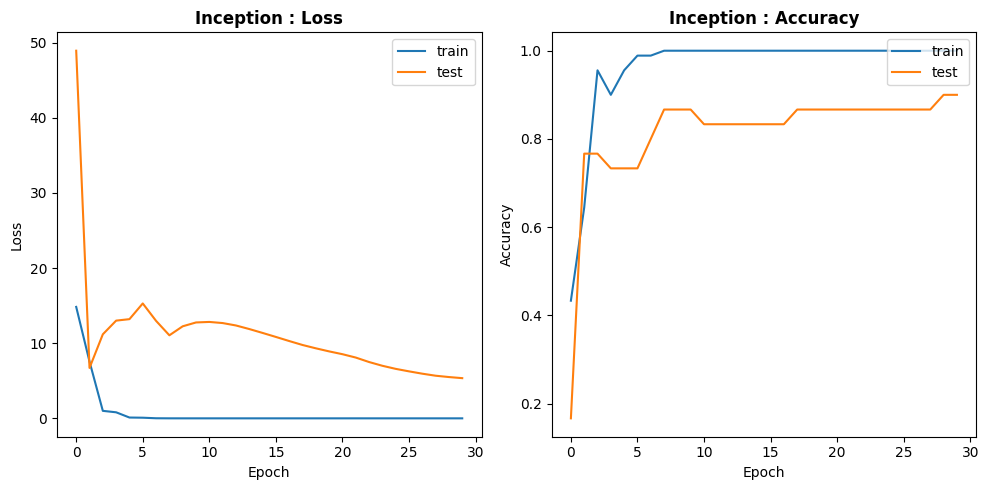

In [39]:
plot_performance(model_name='Inception',
                acc=inception_history.history['accuracy'],
                 val_acc=inception_history.history['val_accuracy'],
                 loss=inception_history.history['loss'],
                 val_loss=inception_history.history['val_loss'])

In [41]:
# Reset model
inception_model = build_inception_model()
# Change filepath to end with .keras or .h5
checkpointer_inception_aug = ModelCheckpoint(filepath='inception_aug.weights.best.keras', verbose=1, save_best_only=True) # or filepath='inception_aug.weights.best.h5'


With Augmentation

In [42]:

# Train with data augmentation
inception_history_aug = inception_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=[checkpointer_inception_aug]
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4375 - loss: 1.5268
Epoch 1: val_loss improved from inf to 5.79574, saving model to inception_aug.weights.best.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.4688 - loss: 1.6003 - val_accuracy: 0.8000 - val_loss: 5.7957
Epoch 2/30
1/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6923 - loss: 3.4601
Epoch 2: val_loss did not improve from 5.79574
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.6923 - loss: 3.4601 - val_accuracy: 0.7333 - val_loss: 14.3884
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8024 - loss: 2.0291
Epoch 3: val_loss did not improve from 5.79574
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - accuracy: 0.7878 - loss: 2.3870 - val_accuracy: 0.7000 - val_loss: 26.0138
Epoch 4/30
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8438 - loss: 0.8289
Epoch 4: val_loss did not improve from 5.79574
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8438 - loss: 0.8289 - val_accura

In [44]:
score3 = inception_model.evaluate(X_test, y_test)
accuracy3 = 100 * score3[1]
print('Test accuracy with augmentation: %.4f%%' % accuracy3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7333 - loss: 55.8833
Test accuracy with augmentation: 73.3333%


In [46]:
model.save('best_model_inception_aug.keras')


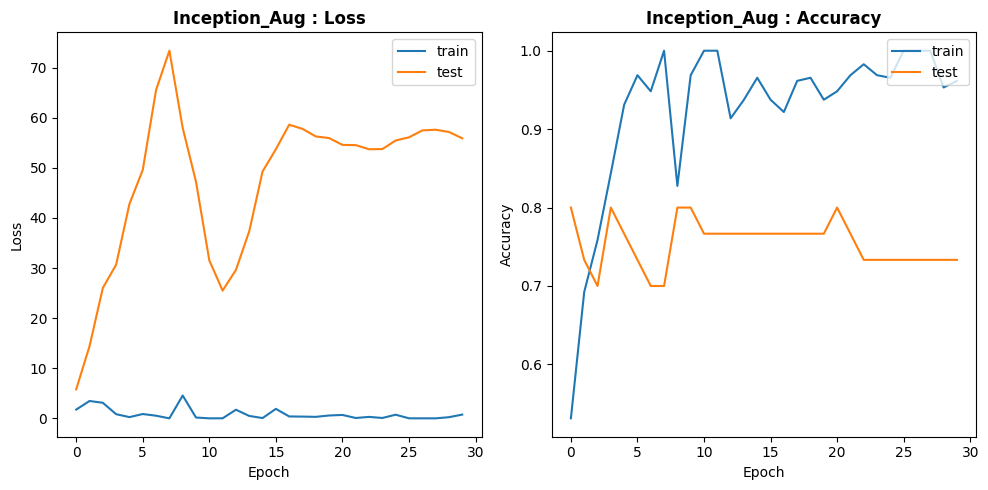

In [47]:

plot_performance(model_name='Inception_Aug',
                acc=inception_history_aug.history['accuracy'],
                 val_acc=inception_history_aug.history['val_accuracy'],
                 loss=inception_history_aug.history['loss'],
                 val_loss=inception_history_aug.history['val_loss'])

Xception

In [48]:

#building fully connected layers
xception_model=Sequential()
xception_base= Xception(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape_3D
)

xception_base.trainable=True
set_trainable=False

for layer in xception_base.layers:
  if layer.name=='add_8':
    set_trainable=True

  if set_trainable==True:
    layer.trainable=True
  else:
    layer.trainable=False


xception_model.add(xception_base)
xception_model.add(Flatten())

xception_model.add(Dense(128, activation='relu'))
xception_model.add(Dense(3, activation='softmax'))

xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


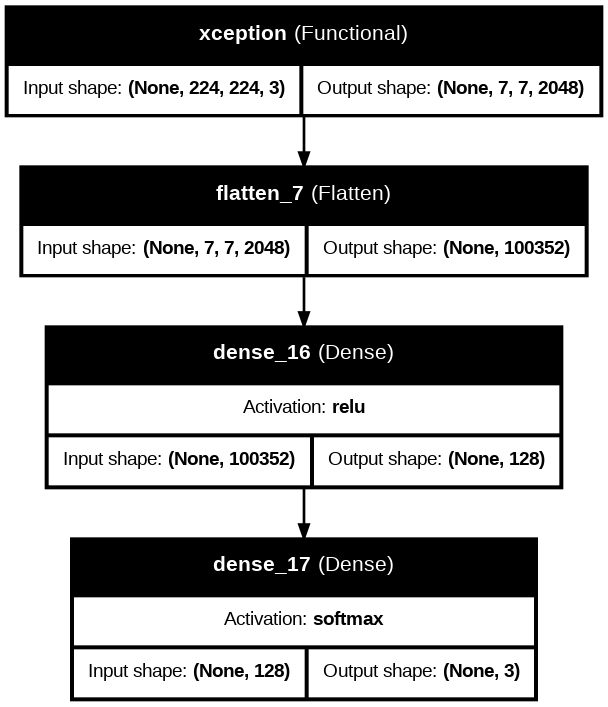

In [49]:
tf.keras.utils.plot_model(
    xception_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

Without Augmentation

In [50]:
def build_xception_model():
    xception_base = Xception(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape_3D
    )

    xception_base.trainable = True
    set_trainable = False

    for layer in xception_base.layers:
        if layer.name == 'add_8':
            set_trainable = True
        layer.trainable = set_trainable

    model = Sequential()
    model.add(xception_base)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Adjust the number of output classes
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [52]:
xception_model = build_xception_model()
checkpointer_xception = ModelCheckpoint(filepath='xception.weights.best.keras', verbose=1, save_best_only=True) # changed extension from hdf5 to keras

xception_history = xception_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[checkpointer_xception]
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3854 - loss: 3.0986   
Epoch 1: val_loss improved from inf to 3.44552, saving model to xception.weights.best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 11s/step - accuracy: 0.4141 - loss: 3.3392 - val_accuracy: 0.7000 - val_loss: 3.4455
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9094 - loss: 0.5160
Epoch 2: val_loss did not improve from 3.44552
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.9070 - loss: 0.6096 - val_accuracy: 0.7000 - val_loss: 5.0317
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9532 - loss: 0.4453
Epoch 3: val_loss did not improve from 3.44552
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.9455 - loss: 0.5162 - val_accuracy: 0.5333 - val_loss: 7.5323
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9613 - loss: 0.1415
Epoch 4: val_loss did not improve from 3.44552
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.9655 - loss: 0.1264 - val_accuracy

In [53]:
score4 = xception_model.evaluate(X_test, y_test) # predicting the model
accuracy4 = 100*score4[1] # saving the accuracy in variable

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7000 - loss: 7.4966
Test accuracy: 70.0000%


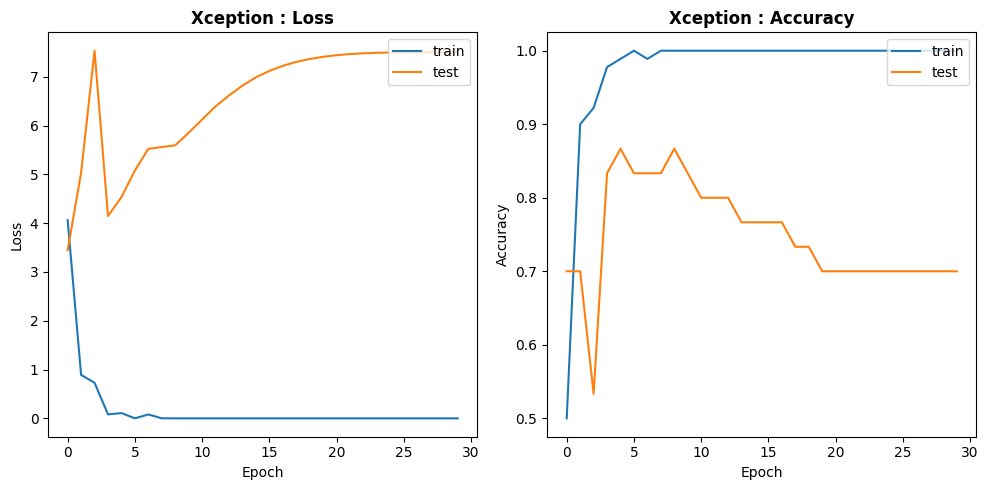

In [54]:
plot_performance(model_name='Xception',
                acc=xception_history.history['accuracy'],
                 val_acc=xception_history.history['val_accuracy'],
                 loss=xception_history.history['loss'],
                 val_loss=xception_history.history['val_loss'])

With Augmentation

In [57]:
xception_model = build_xception_model()
checkpointer_xception_aug = ModelCheckpoint(filepath='xception_aug.weights.best.keras', verbose=1, save_best_only=True)


xception_history_aug = xception_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=[checkpointer_xception_aug]
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4219 - loss: 6.5889
Epoch 1: val_loss improved from inf to 26.08539, saving model to xception_aug.weights.best.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.4271 - loss: 8.3899 - val_accuracy: 0.4333 - val_loss: 26.0854
Epoch 2/30
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.3462 - loss: 20.1123
Epoch 2: val_loss improved from 26.08539 to 4.71328, saving model to xception_aug.weights.best.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3462 - loss: 20.1123 - val_accuracy: 0.5000 - val_loss: 4.7133
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.6565 - loss: 3.0648
Epoch 3: val_loss did not improve from 4.71328
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 837ms/step - accuracy: 0.6446 - loss: 3.1685 - val_accuracy: 0.3000 - val_loss: 8.9022
Epoch 4/30
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7812 - loss: 1.9720
Epoch 4: val_loss did not improve from 4.71328
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 182

In [58]:
score5 = xception_model.evaluate(X_test, y_test) # predicting the model
accuracy5 = 100*score5[1] # saving the accuracy in variable

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7000 - loss: 1.4388
Test accuracy: 70.0000%


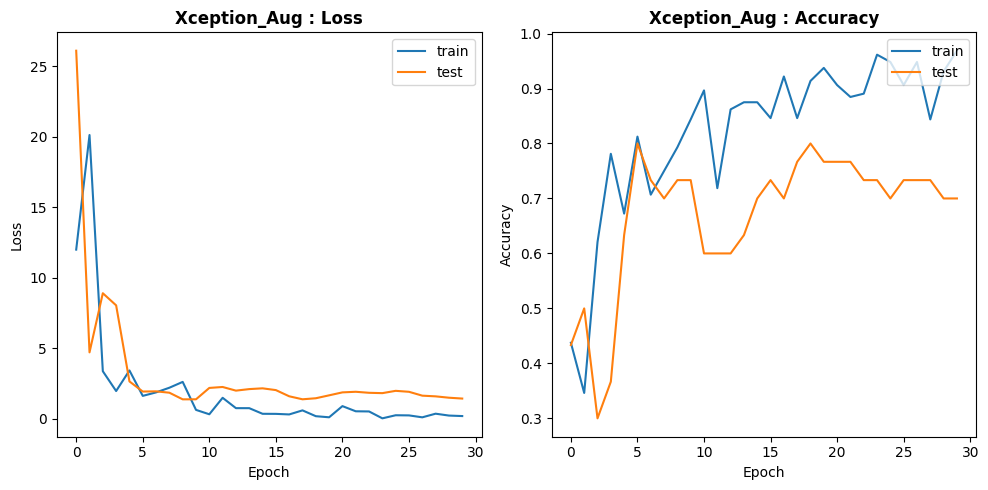

In [59]:
plot_performance(model_name='Xception_Aug',
                acc=xception_history_aug.history['accuracy'],
                 val_acc=xception_history_aug.history['val_accuracy'],
                 loss=xception_history_aug.history['loss'],
                 val_loss=xception_history_aug.history['val_loss'])

In [62]:
# creating dataframe for model camparison
import pandas as pd
score = pd.DataFrame({"Model":["CNN","CNN With Data Augumentaion","InceptionV3 Without Data Augmentation","InceptionV3 With Data Augmentation","Xception Without Data Augmentation","Xception With Data Augmentation"],
                     "accuracy":[accuracys,accuracy1,accuracy2,accuracy3,accuracy4,accuracy5]
                     })


In [63]:
score

,Model,accuracy
0,CNN,60.000002
1,CNN With Data Augumentaion,20.000000
2,InceptionV3 Without Data Augmentation,89.999998
3,InceptionV3 With Data Augmentation,73.333335
4,Xception Without Data Augmentation,69.999999
5,Xception With Data Augmentation,69.999999


In [64]:
# Function to Load and Preprocess the Image using Pillow
from PIL import Image
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(cnn_model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = cnn_model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [68]:
# Create a training data generator with labels
train_generator = datagen.flow(X_train, y_train, batch_size=30, shuffle=False)

# Get the class indices from the generator
class_indices = {i: class_names[i] for i in range(len(class_names))}

In [69]:
class_indices

{0: 'Bacterial leaf blight', 1: 'Brown spot', 2: 'Leaf smut'}

In [70]:
# saving the class names as json file
import json
json.dump(class_indices, open('class_indices.json', 'w'))

In [73]:
# Function to Load and Preprocess the Image using Pillow
from PIL import Image
def load_and_preprocess_image(image_path, target_size=(224, 224)): # Changed target_size to (224, 224)
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(inception_model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = inception_model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [74]:
image_path = '/content/drive/MyDrive/rice_leaf_diseases/Bacterial leaf blight/DSC_0372.JPG'
predicted_class_name = predict_image_class(, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted Class Name: Bacterial leaf blight


In [75]:
inception_model.save('Rice_leaf_disease_detection.h5')